# Introduction to Probabilistic Modeling

This notebook introduces the probabilistic modeling primitives provided by `fwd_model_tools`. We cover:

1. **Custom distributions for MCMC** — `PreconditionnedUniform` and `ProbitTransform`, which reparameterize bounded parameters into unconstrained Gaussian space for efficient HMC/NUTS sampling.
2. **Sampling initial conditions** — `DistributedNormal` for white noise and `DistributedIC` for directly sampling cosmological density fields with correct power spectrum structure.

These building blocks are used by the full Bayesian inference pipeline in notebook 11.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro.infer.reparam import TransformReparam
from numpyro.handlers import reparam

import fwd_model_tools as ffi
from fwd_model_tools.sampling.dist import (
    DistributedIC,
    DistributedNormal,
    PreconditionnedUniform,
)

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2026-02-17 11:06:56,364:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/j

## 1. Custom Distributions and MCMC

HMC and NUTS samplers work best in unconstrained spaces. When we have bounded parameters (e.g. $\Omega_m \in [0.1, 0.5]$), naively sampling a uniform prior leads to wasted proposals at the boundaries.

`PreconditionnedUniform` solves this by composing two transforms:
- **`ProbitTransform`** — maps $\mathbb{R} \to (0, 1)$ using the standard normal CDF ($\Phi$)
- **`AffineTransform`** — rescales $(0, 1) \to (\text{low}, \text{high})$

The sampler explores an unconstrained Gaussian space (the "base" space), while the model sees uniform samples in the bounded domain.

Let's demonstrate this with a simple 1D model.

In [2]:
def simple_model():
    # Sample x from a preconditioned uniform on [-3, 3]
    # Under the hood, NUTS explores a standard Normal (the "base" space)
    with reparam(config={"x": TransformReparam()}):
        x = numpyro.sample(
            "x",
            PreconditionnedUniform(low=-3.0, high=3.0),
        )

# Run MCMC
kernel = NUTS(simple_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=10_000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

The MCMC produces three related quantities:

- **`y`** — the observed variable (fixed at 1.0)
- **`x`** — the parameter of interest, living in $[-3, 3]$
- **`x_base`** — the unconstrained Gaussian variable that NUTS actually explores

Let's visualize all three to see the reparameterization in action.

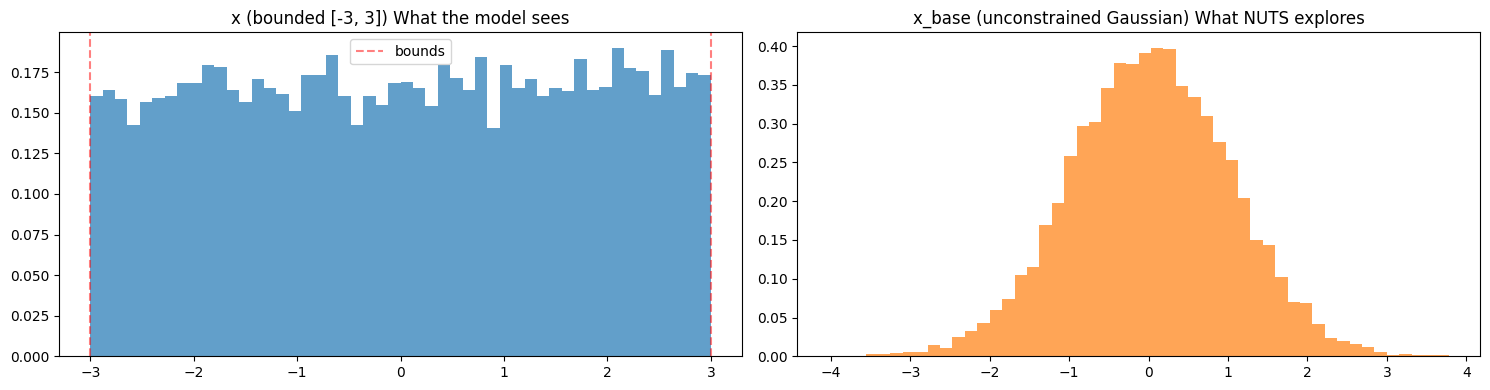

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))


# Final x in bounded space
axes[0].hist(samples["x"], bins=50, density=True, alpha=0.7, color="tab:blue")
axes[0].axvline(-3.0, color="red", linestyle="--", alpha=0.5)
axes[0].axvline(3.0, color="red", linestyle="--", alpha=0.5, label="bounds")
axes[0].set_title("x (bounded [-3, 3]) What the model sees")
axes[0].legend()
# Base space (unconstrained Gaussian)
axes[1].hist(samples["x_base"], bins=50, density=True, alpha=0.7, color="tab:orange")
axes[1].set_title("x_base (unconstrained Gaussian) What NUTS explores")

plt.tight_layout()
plt.show()

## 2. Sampling Initial Conditions

Cosmological initial conditions are Gaussian random fields whose statistics are fully described by the matter power spectrum $P(k)$. We can express this as a generative model:

$$\delta(\mathbf{k}) = \sqrt{P(k)} \cdot \epsilon(\mathbf{k}), \quad \epsilon \sim \mathcal{N}(0, 1)$$

There are two ways to sample ICs in a NumPyro model:

| Approach | Distribution | What it samples | Power spectrum applied by |
|----------|-------------|-----------------|-------------------------|
| Manual | `DistributedNormal` | White noise $\epsilon$ | You call `interpolate_initial_conditions` |
| Reparameterized | `DistributedIC` | Density field $\delta$ directly | Built into the distribution's transform |

In [4]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro.infer.reparam import TransformReparam
from numpyro.handlers import reparam

import fwd_model_tools as ffi
from fwd_model_tools.sampling.dist import (
    DistributedIC,
    DistributedNormal,
    PreconditionnedUniform,
)
# Simulation parameters
mesh_size = (32, 32, 32)
box_size = (250.0, 250.0, 250.0)
cosmo = jc.Planck18()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Approach 1: Without Reparameterization

Sample white noise from `DistributedNormal(0, 1)`, then manually apply the power spectrum via `interpolate_initial_conditions`. This gives you explicit control over the pipeline stages.

In [5]:
def ic_model_manual():
    """Sample white noise, then apply power spectrum manually."""
    white_noise = numpyro.sample(
        "white_noise",
        DistributedNormal(
            loc=jnp.zeros(mesh_size),
            scale=jnp.ones(mesh_size),
            mesh_size=mesh_size,
            box_size=box_size,
        ),
    )
    # white_noise is now a DensityField — extract .array for manual interpolation
    field = ffi.interpolate_initial_conditions(
        white_noise.array, mesh_size, box_size, cosmo=cosmo,
    )
    numpyro.deterministic("density_field", field.array)


# Draw one forward sample using Predictive (no MCMC needed)
predictive = Predictive(ic_model_manual, num_samples=1)
key = jax.random.PRNGKey(42)
manual_samples = predictive(key)

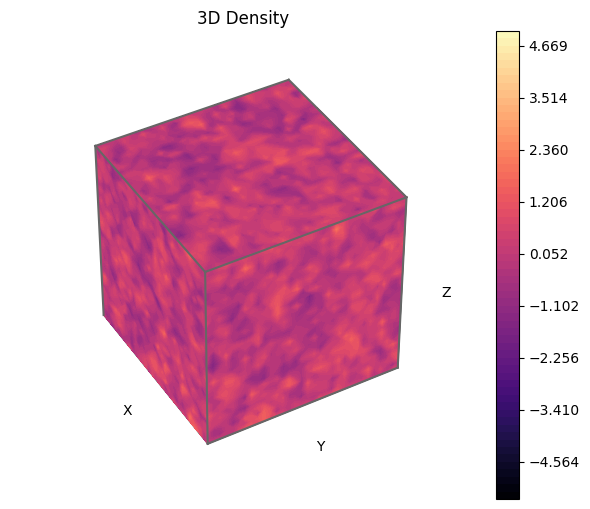

In [6]:
# Wrap the result in a DensityField for visualization
manual_field = ffi.DensityField(
    array=manual_samples["density_field"][0],
    mesh_size=mesh_size,
    box_size=box_size,
    status=ffi.FieldStatus.INITIAL_FIELD,
    unit=ffi.units.DENSITY
)
manual_field.show()

### Approach 2: With Reparameterization

`DistributedIC` is a `TransformedDistribution` that encapsulates the entire IC generation pipeline:
- Base distribution: `DistributedNormal(0, 1)` (white noise)
- Transform: `PowerSpectrumTransform` (FFT-based power spectrum interpolation)

When combined with `TransformReparam`, NUTS explores the white-noise base space while the model works with the physical density field. This is analogous to the `PreconditionnedUniform` example above, but for 3D fields.

In [7]:
def ic_model_reparam():
    """Sample ICs directly via DistributedIC + reparameterization."""
    with reparam(config={"initial_conditions": TransformReparam()}):
        density_field = numpyro.sample(
            "initial_conditions",
            DistributedIC(mesh_size, box_size, cosmo=cosmo),
        )

# Draw one forward sample
predictive = Predictive(ic_model_reparam, num_samples=1)
reparam_samples = predictive(jax.random.PRNGKey(42))

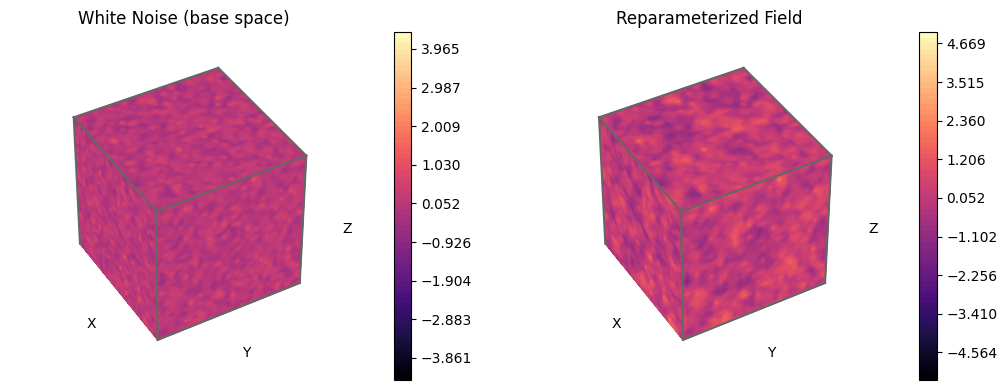

In [8]:
# Samples are now DensityFields — select first sample from the batch dimension
reparam_field = reparam_samples["initial_conditions"].replace(
    array=reparam_samples["initial_conditions"].array[0]
)
white_noise = reparam_samples["initial_conditions_base"].replace(
    array=reparam_samples["initial_conditions_base"].array[0]
)
figure, axes = plt.subplots(1, 2, figsize=(15, 4), subplot_kw={"projection": "3d"})
white_noise.plot(ax=axes[0], titles="White Noise (base space)")
reparam_field.plot(ax=axes[1], titles="Reparameterized Field")
plt.tight_layout()
plt.show()

In [9]:
def ic_model():
    """Sample ICs directly via DistributedIC + reparameterization."""
    density_field = numpyro.sample(
        "initial_conditions",
        DistributedIC(mesh_size, box_size, cosmo=cosmo),
    )

# Draw one forward sample
mcmc = MCMC(NUTS(ic_model), num_warmup=2, num_samples=10, progress_bar=True)
mcmc.run(jax.random.PRNGKey(42))

sample: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s, 1 steps of size 2.71e+00. acc. prob=0.00]
